<a href="https://colab.research.google.com/github/Strojove-uceni/23206-final-acoustic-emission-classification/blob/main/AE_classificatio_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing the Drill - Acoustic Emission Classification
* Barbora Bumbálková, Jan Zavadil
## Abstract
The goal of this project is to find an automated, reliable and cheap method to monitor the level of sharpness of a drill in a manufacturing line in order to facilitate optimal replacement of worn bits. The chosen approach relies on the phenomenon of acoustic emission - the process of solid materials emmiting ultrasound waves during irreversible structural changes. Acoustic emission (AE) signals are measured with sensors on the surface of an object of interest during drilling, the level of drill sharpness is also recorded. In our setup, we measured AE signals with five different levels of drill sharpness, which led us to formulate a simple classification machine learning task with five classes. We deployed multiple neural network architectures relying on 1D convolutional layers to perform the featurization of measured signals followed by a fully connected network performing the classification. All classification methods implemented surpassed the results of non DNN based clyssifiers, the best classifying with accuracy of over 89%.

**Make sure you are using a colab GPU to speed up evaluation**

Detailed training flow of neural networks along with the development and optimization process can be seen on [WandB](https://wandb.ai/hzavadil98) page as well as the full training scripts.

In [ ]:
# @title Imports and Helper Functions
%%capture
!pip install lightning
!pip3 install wandb
!pip install torchview

import torchview
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import requests
import IPython

from collections import OrderedDict
from IPython.display import Image
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torchmetrics.classification import Accuracy, MulticlassConfusionMatrix
from pytorch_lightning.utilities.model_summary import ModelSummary
from torch import argmax
from sklearn.preprocessing import StandardScaler

#Connecting git repository
!git clone https://github.com/Strojove-uceni/23206-final-acoustic-emission-classification.git

#Creates torch.Dataset
class SignalDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        signal = self.data[index]
        label = self.labels[index]
        return signal, label

In [ ]:
# @title Loading test data from the repository
path = '/content/23206-final-acoustic-emission-classification/data/Test_dataset_seed=43.pkl'
with open(path, 'rb') as pickle_file:
            loaded_data = pickle.load(pickle_file)
X_test_np = loaded_data['X_test']
X_test_np = np.moveaxis(X_test_np,1,2)
y_test = loaded_data['y_test']
y_test = nn.functional.one_hot(torch.from_numpy(y_test)).float()

## Methodology
### 1. Experiment
An experiment was carried out in cooperation with the Institute of Thermomechanics of CAS to provide a dataset imitating a production process. The experiment setup is on the following picture.
<div>
<img src=https://drive.google.com/uc?export=view&id=1-fw3ArRU-Iz2MzfyMHi13tauq9PN0Fnh width="500">
</div>


AE signals were detected by four piezoelectric sensors. For each level of sharpness of the drill a few seconds long period of drilling under constant pressure was measured, then the drill was taken out and manually blunted by a grinding stone.

### 2. Data preparation

The sampling frequency was 3,125 MHz, so the resulting signals of continuous AE were unbearably long for any direct analysis. For this reason shorter sections - samples - were randomly cut out from the original signals. The cuts were synchronised along four channels coming from the four sensors used. After a few attempts the length of samples was chosen to be 6000 as it still allowed relatively easy manipulation with the data. In total 2500 samples were extracted for each of five sharpness levels, resulting in our final dataset being of the dimensions (12500, 4, 6000). In the figure below, first data sample of the first category is displayed.

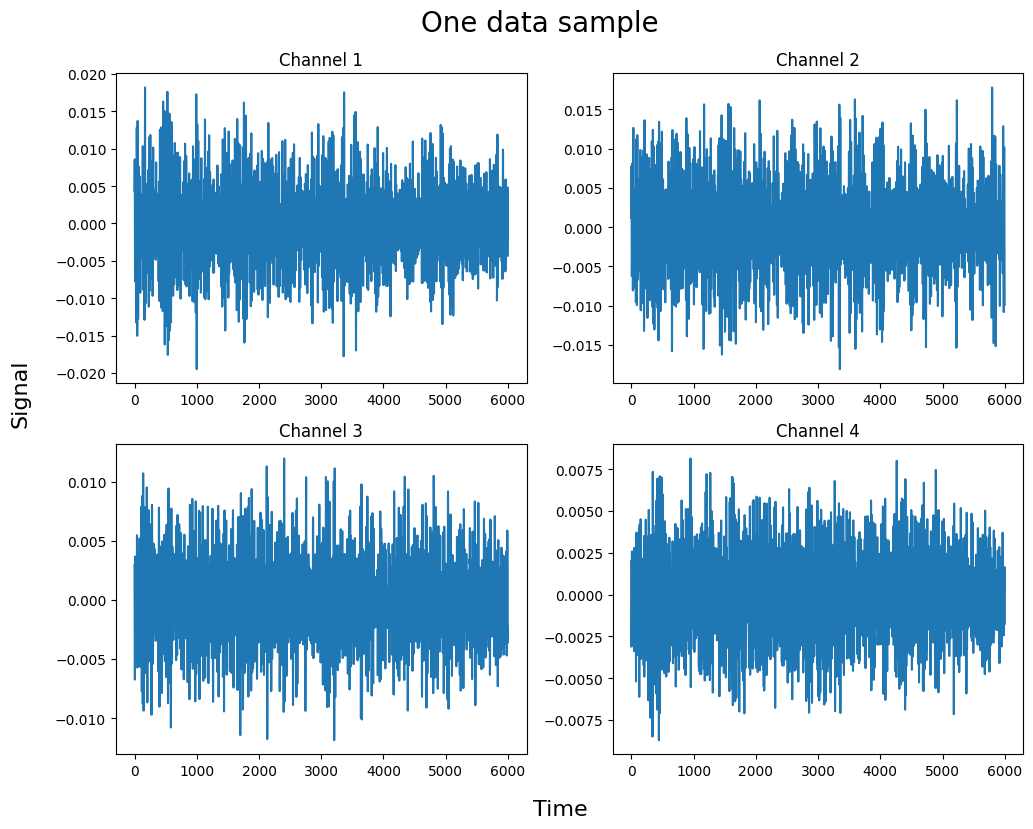

In [ ]:
# @title Data Visualisation
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(X_test_np[0, 0, :])
axs[0, 0].set_title('Channel 1')

axs[0, 1].plot(X_test_np[0, 1, :])
axs[0, 1].set_title('Channel 2')

axs[1, 0].plot(X_test_np[0, 2, :])
axs[1, 0].set_title('Channel 3')

axs[1, 1].plot(X_test_np[0, 3, :])
axs[1, 1].set_title('Channel 4')

fig.text(0.52, -0.02, 'Time', ha='center', va='center', size = 16)
fig.text(-0.02, 0.5, 'Signal', ha='center', va='center', rotation='vertical', size = 16)

fig.suptitle('One data sample', fontsize=20)
# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Show the plot
plt.show()

### 3. Classification
To train the implemented networks the data was randomly separated into *Train/Validation/Test* datasets in ratio 7/2/1. In the following demo only the *Test* dataset is loaded and used as it would be very memory and time demanding to train the networks here. Networks were trained on FNSPE computing cluster Helios and the learned weights are imported. Individual architectures implemented will be further described in the Code&Results part, all of them are based on convolutional layers as they suit our, rather data intensive, task the best, inspiration was drawn from image classification applications.





## Code&Results

In [ ]:
#Creates test dataloader - not neccesary to declare pl.DataModule for our use here
X_test = torch.from_numpy(X_test_np).float()
test_dataset = SignalDataset(X_test, y_test)
test_DataLoader = DataLoader(test_dataset, batch_size=32, num_workers=1)

In [ ]:
# @title Definition of the backbone (parent) of all our neural networks
class MyModule(pl.LightningModule):
    def __init__(self, ):
        super(MyModule, self).__init__()

        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=5)
        self.test_pred = []  # collect predictions
        self.confusion_matrix = MulticlassConfusionMatrix(num_classes=5)
        self.check_path = 'Early_Stopping_checkpoint.pth'
        self.min_val_loss = np.inf
        self.best_epoch = 0



    def forward(self, x):
        return x

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        loss = self.loss(outputs, labels)
        self.log('train_loss', loss, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        y_target = argmax(labels, dim=1)
        y_pred = argmax(outputs, dim=1)

        acc = self.accuracy(y_pred, y_target)
        self.log('train_accuracy', acc, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        loss = self.loss(outputs, labels)
        self.log('val_loss', loss, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        y_target = argmax(labels, dim=1)
        y_pred = argmax(outputs, dim=1)
        acc = self.accuracy(y_pred, y_target)
        self.log('val_accuracy', acc, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        loss = self.loss(outputs, labels)
        self.log('test_loss', loss, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        y_target = argmax(labels, dim=1)
        y_pred = argmax(outputs, dim=1)
        acc = self.accuracy(y_pred, y_target)
        self.log('test_accuracy', acc, sync_dist=True, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # Collect predictions
        self.test_pred.extend(y_pred.cpu().numpy())
        # Update confusion matrix
        self.confusion_matrix.update(y_pred, y_target)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def on_validation_epoch_end(self):
        validation_loss = self.trainer.callback_metrics['val_loss']
        if validation_loss < self.min_val_loss:
            self.min_val_loss = validation_loss
            torch.save(self.state_dict(), self.check_path)
            self.best_epoch = self.current_epoch

    def on_train_end(self):
        print(f'Best epoch was epoch {self.best_epoch}. Loading its state.')
        self.load_state_dict(torch.load(self.check_path))




## 1. ConvNet2 network

---
The first implemented neural network is directly inspired by LeNet, which was used for image classification. In our 1D application it was necessary to use much bigger filters (ie. 1x501 instead of 5x5 in LeNet) as patterns useful for classification in signals can spread over longer distance. The network itself connsists of two convolutional layers in tandem with maximum pooling layers followed by a fully connected part. Visualisation of the network follows its definition.



In [ ]:
# @title Definition of pl.LightningModule for ConvNet2
class ConvNet2(MyModule):
    def __init__(self, input_channels, num_class, drop):
        super(ConvNet2, self).__init__()

        # input_channels - number of channels in input data - 4 in our case
        # num_class - number of classes to which we classify
        # drop - value of dropout probability used in training (0.1 used)

        self.drop = drop

        #The actual definition of nn
        self.all_layers = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=501),
            nn.ReLU(),
            nn.Dropout(self.drop),
            nn.MaxPool1d(kernel_size=5),

            nn.Conv1d(64,64, kernel_size=81),
            nn.ReLU(),
            nn.Dropout(self.drop),
            nn.MaxPool1d(kernel_size=4),

            nn.Flatten(),

            nn.Linear(64*255, 200),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(50, num_class))


    def forward(self, x):
        return self.all_layers(x)


In [ ]:
#Model inititalisation
model = ConvNet2(input_channels = 4, num_class = 5, drop = 0.1)
#Loading weights
model.load_state_dict(torch.load('/content/23206-final-acoustic-emission-classification/data/VRTY_orig_CNN_state_dict'))
#print(model)

<All keys matched successfully>

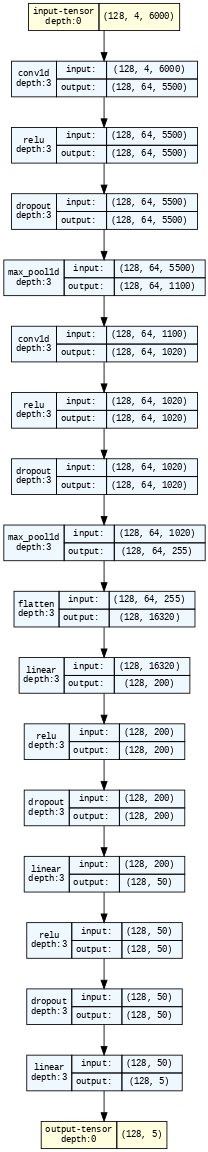

In [ ]:
# @title Network Visualisation
#creates a graph visualization of the network
model_graph_1 = torchview.draw_graph(
    model, input_size=(128, 4, 6000),
    graph_name='2Conv',
    hide_inner_tensors=True,
    hide_module_functions=False,
    save_graph = True,
    show_shapes = True,
)
display(Image(filename='/content/2Conv.gv.png'))

Considering large memory demands, it was necessary to train the model remotely. Wandb turned out to be a great tool to evaluate and visualize often marginal changes in the training process. Figure depicting the value of loss (CrossEntropyLoss) on training and validation datasets throughout the learning process is displayed below. Early stopping was employed to find optimal number of epochs with the patience parameter set to 20. After finalizing training weights from the best epoch (128) were loaded.

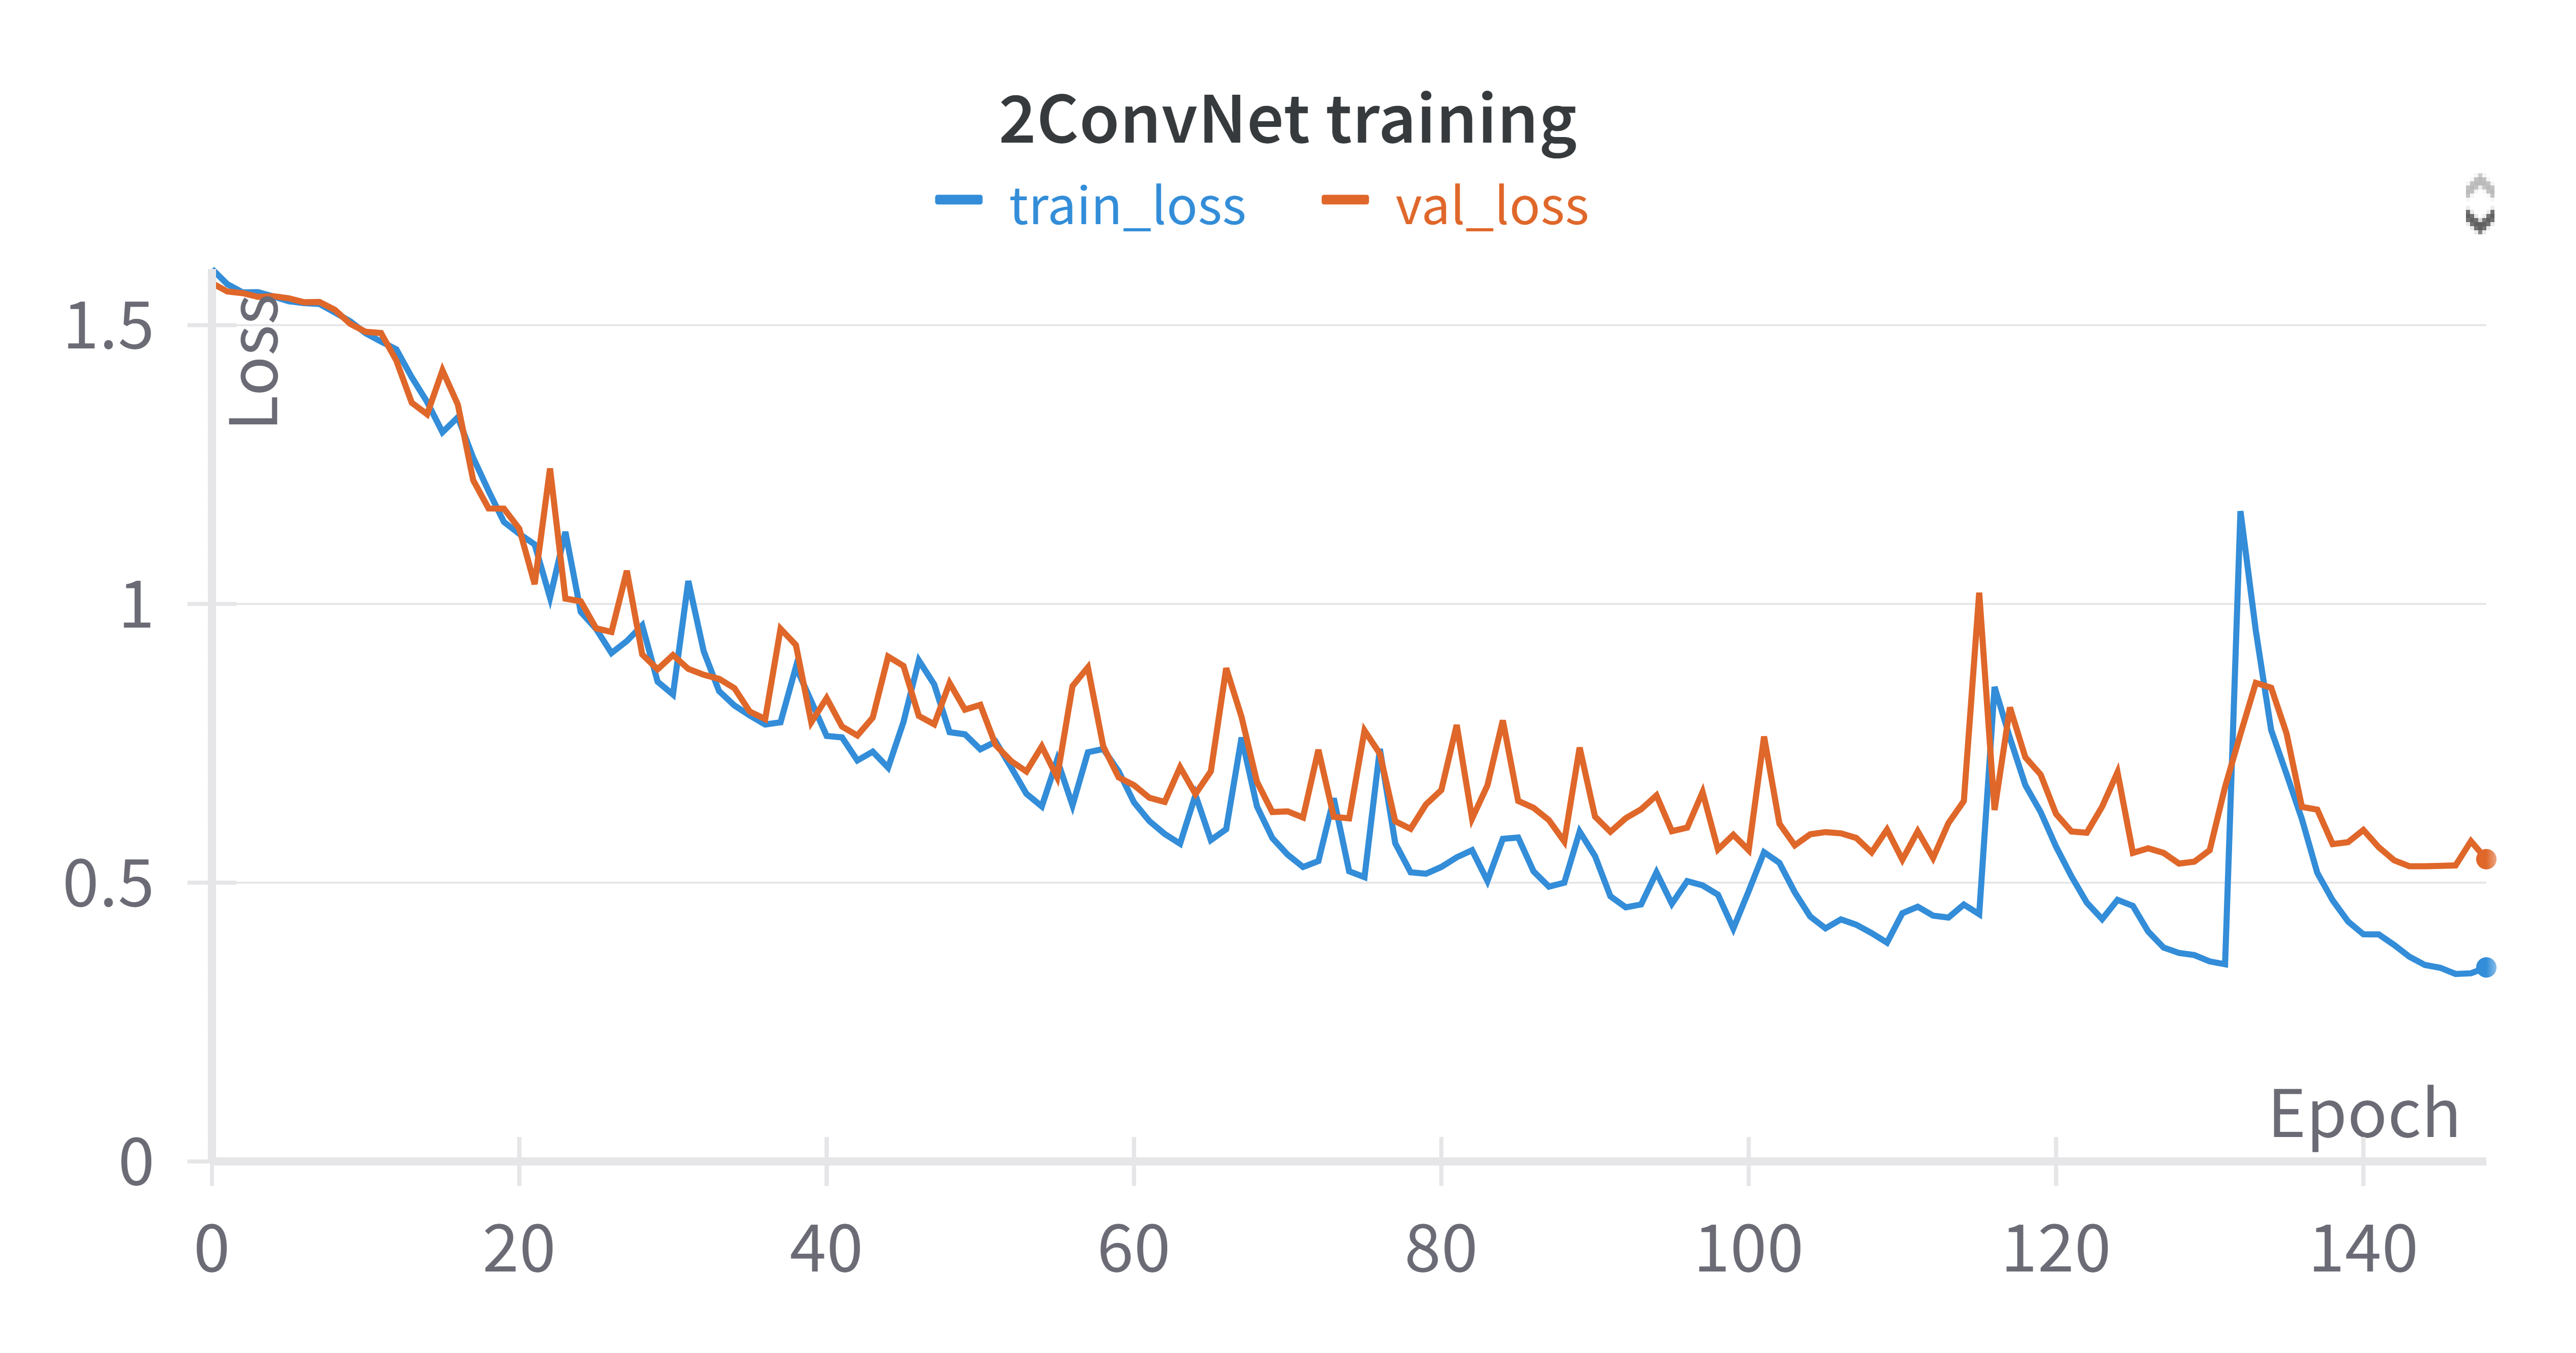

In [ ]:
# Shows trining figure
display(Image(filename='/content/23206-final-acoustic-emission-classification/data/2ConvNet_training.png'))

The following code initializes the lightning trainer and evaluates model performance on Test_dataset. It reaches accuraccy of almost 79%. Our dataset was balanced, so accuracy itself is sufficient to give us a good idea about models performance.

In [ ]:
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

trainer = pl.Trainer(devices=ngpus, accelerator="gpu" if torch.cuda.is_available() else "cpu", max_epochs = 100, log_every_n_steps = 10)

trainer.test(model, test_DataLoader)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7888000011444092     │
│         test_loss         │    0.5171666741371155     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5171666741371155, 'test_accuracy': 0.7888000011444092}]

## 2. ResConvNet

---

The second implemented network was inspired by ResNet architecture. It uses a helper module *BasicBlock1D* which consists of four consecutive convolutional layers with a residual connection around all of them. The network runs the data through four of these blocks with max pooling layers in between of them. As the length of the data decreases due to pooling, the number of channels increases to prevent too much information loss. Rather extensive visualisation of the network follows its definition.

In [ ]:
# @title Definition of pl.LightningModule for ResConvNet

class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kern_size, drop = 0, stride=1):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kern_size, stride=stride, padding='same', bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kern_size, stride=1, padding='same', bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=kern_size, stride=1, padding='same', bias=False)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.conv4 = nn.Conv1d(out_channels, out_channels, kernel_size=kern_size, stride=1, padding='same', bias=False)
        self.bn4 = nn.BatchNorm1d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        self.dropout = nn.Dropout(drop)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv4(out)
        out = self.bn4(out)

        identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out

class ResCNNClassifier(MyModule):
    def __init__(self, input_channels, num_class, drop):
        super(ResCNNClassifier, self).__init__()

        self.drop = drop

        self.block1 = BasicBlock1D(in_channels=input_channels, out_channels=16, kern_size=501, drop=drop)
        self.block2 = BasicBlock1D(in_channels=16, out_channels=32, kern_size=151, drop=drop)
        self.block3 = BasicBlock1D(in_channels=32, out_channels=64, kern_size=71, drop=drop)
        self.block4 = BasicBlock1D(in_channels=64, out_channels=64, kern_size=31, drop=drop)

        self.maxPool1 = nn.MaxPool1d(kernel_size = 4)
        self.maxPool2 = nn.MaxPool1d(kernel_size = 3)
        self.maxPool3 = nn.MaxPool1d(kernel_size = 2)

        self.fc = nn.Sequential(
            nn.Linear(64*250, 200),
            nn.ReLU(),
            nn.Dropout(self.drop),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Dropout(self.drop),
            nn.Linear(50, num_class))


    def forward(self, x):
        x = self.block1(x)
        x = self.maxPool1(x)

        x = self.block2(x)
        x = self.maxPool2(x)

        x = self.block3(x)
        x = self.maxPool3(x)

        x = self.block4(x)

        x = x.view(x.size(0), -1)

        return self.fc(x)


In [ ]:
#Model initialisation
Res_model = ResCNNClassifier(input_channels = 4, num_class = 5, drop = 0.1)
#Loading weights
Res_model.load_state_dict(torch.load('/content/23206-final-acoustic-emission-classification/data/VRTY_residual_CNN_vital_cosmos'))
#print(Res_model)

<All keys matched successfully>

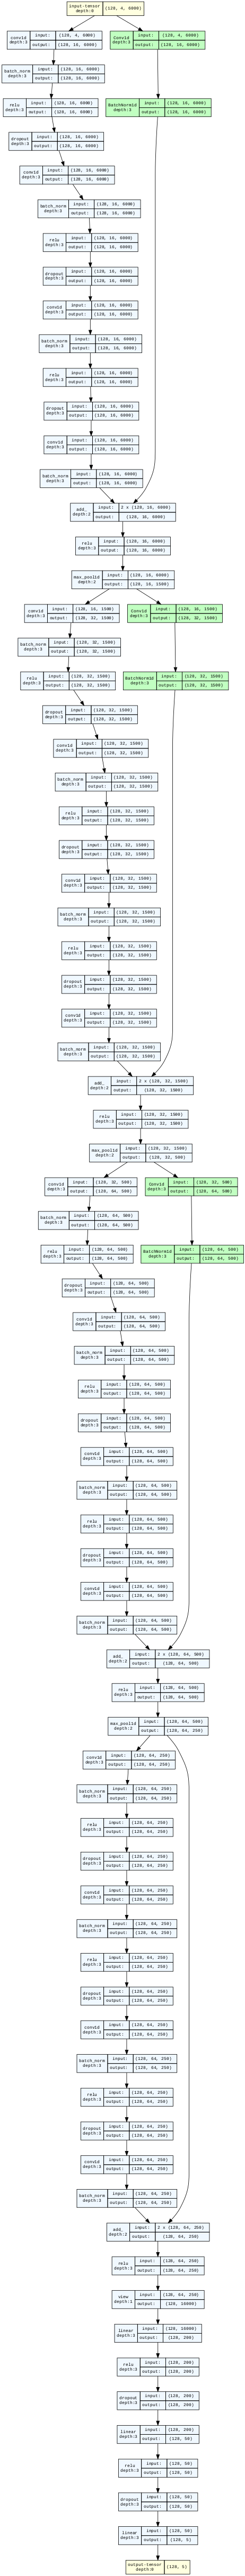

In [ ]:
# @title Network visualisation
model_graph_1 = torchview.draw_graph(
    Res_model, input_size=(128, 4, 6000),
    graph_name='ResConvNet',
    hide_inner_tensors=True,
    hide_module_functions=False,
    save_graph = True,
    show_shapes = True,
)
display(Image(filename='/content/ResConvNet.gv.png'))

Training and optimalising the ResConvNet was much more difficult compared to the previous architecture as many more hyperparameters and settings were necessary to tweak and validation loss was very unstable. The networks tends to overfit much more than the previous one, however when using the early stopping with patience of 80 epochs we were able to reach training/validation accuracies of 86.6%/80.9% at epoch 77, which seems like a good compromise. This is backed by the fact that the network classifies the Test dataset with accuracy of 82.6% as seen below.

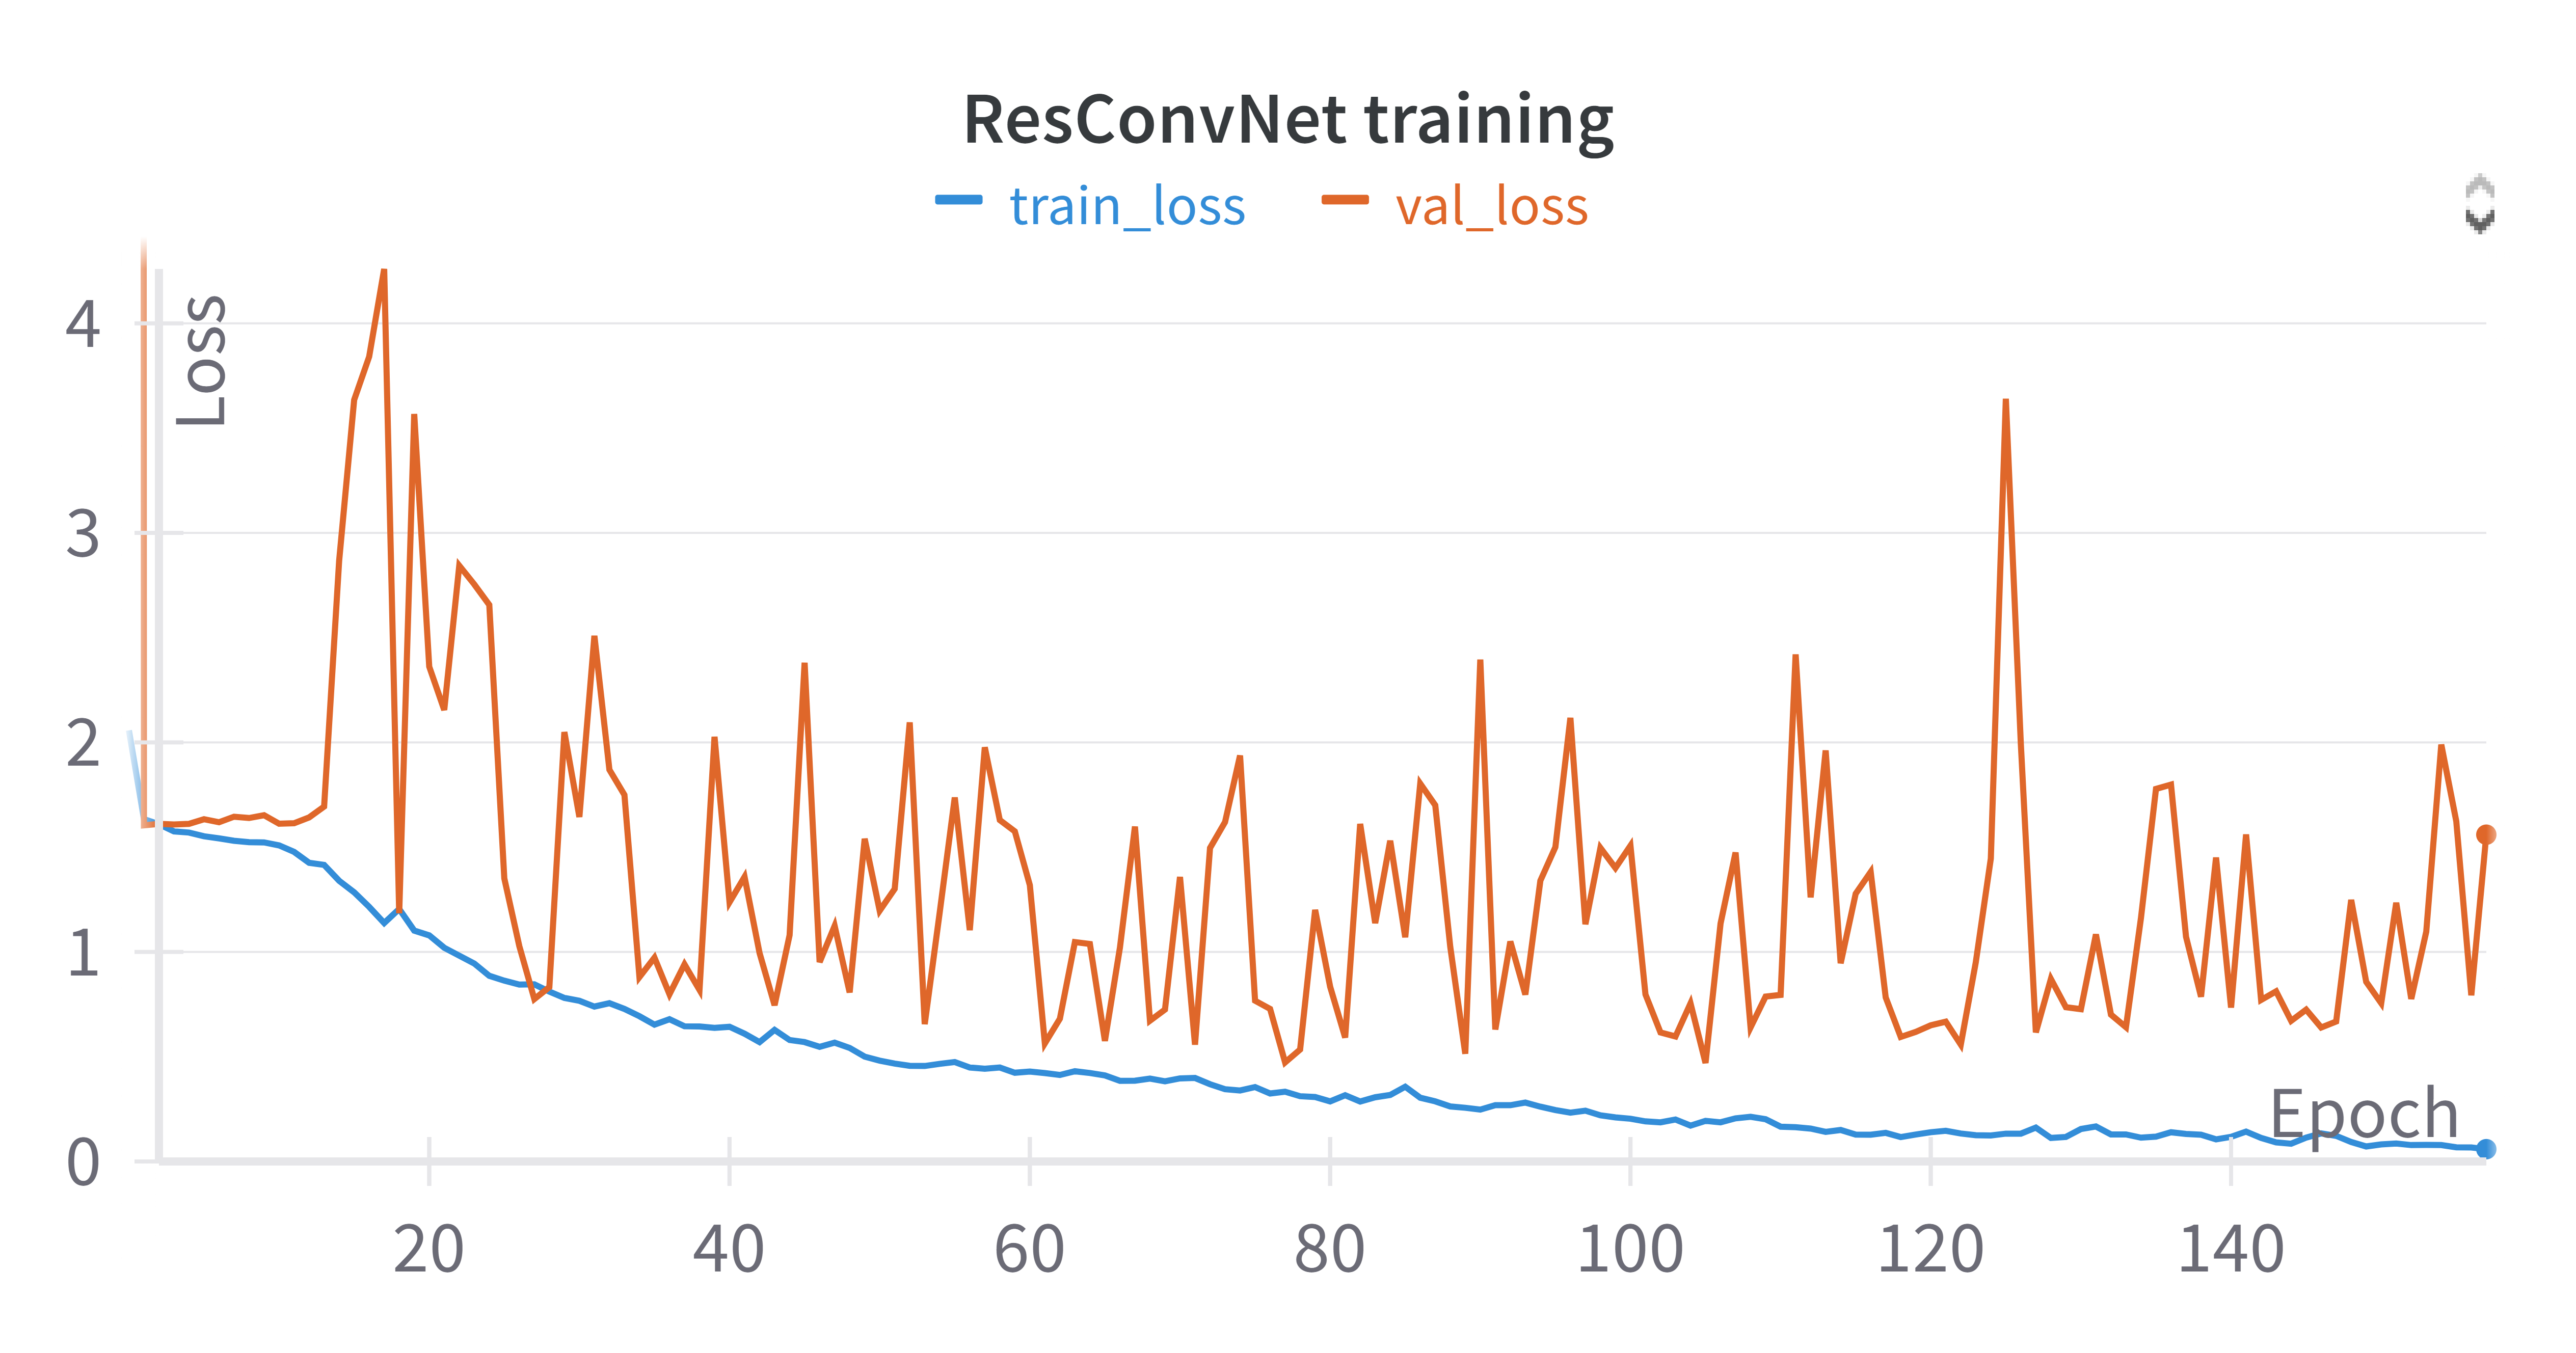

In [ ]:
# Shows loss during training
display(Image(filename='/content/23206-final-acoustic-emission-classification/data/ResConvNet_training.png'))

In [ ]:
# Evaluation of the test dataset
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

trainer = pl.Trainer(devices=ngpus, accelerator="gpu" if torch.cuda.is_available() else "cpu", max_epochs = 100, log_every_n_steps = 10)

trainer.test(Res_model, test_DataLoader)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8256000280380249     │
│         test_loss         │    0.4793238341808319     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4793238341808319, 'test_accuracy': 0.8256000280380249}]

## 3. IncTimeNet

---

Next implemented neural network takes advantage of the InceptionTime module presented in [1]. Structure of one Inception block can be seen in the picture below. For our data it turned out to be beneficial to increase the lengths of convolution filters used from 10/20/40 to 41/101/301. The classification network itself then consisted of three Inception blocks with a residual connection around all of them. The main dimension reduction in the network is subsequently applied in the form of averageing over the whole (!!)  time dimension of the data. Quite surprisingly this drastic method seems to be very efficient. Eventually fully connected layers are used to transform the data into five output neurons. This time network visualisation, found after network definition, is very useful for understanding its structure (and is much smaller than for ResConvNet).

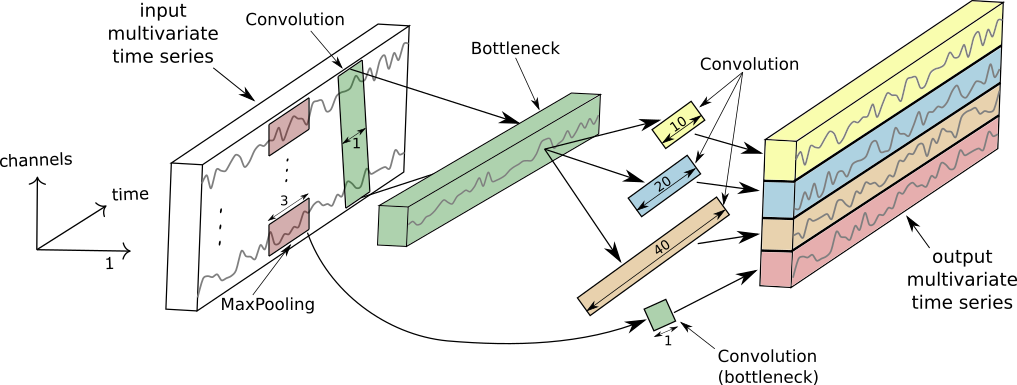

In [ ]:
# Shows loss during training
display(Image(filename='/content/23206-final-acoustic-emission-classification/data/Inc_time_picture.png'))

In [ ]:
# @title Definition of pl.LightningModule for IncTimeNet
class Inception(torch.nn.Module):
    def __init__(self, in_size, out_size, filters = [11, 21, 41]):
        super(Inception, self).__init__()

        self.bottleneck1 = torch.nn.Conv1d(
            in_channels=in_size,
            out_channels=out_size,
            kernel_size=1,
            stride=1,
            padding='same',
            bias=False
        )

        self.conv1 = torch.nn.Conv1d(
            in_channels=out_size,
            out_channels=out_size,
            kernel_size=filters[0],
            stride=1,
            padding='same',
            bias=False
        )

        self.conv2 = torch.nn.Conv1d(
            in_channels=out_size,
            out_channels=out_size,
            kernel_size=filters[1],
            stride=1,
            padding='same',
            bias=False
        )

        self.conv3 = torch.nn.Conv1d(
            in_channels=out_size,
            out_channels=out_size,
            kernel_size=filters[2],
            stride=1,
            padding='same',
            bias=False
        )

        self.max_pool = torch.nn.MaxPool1d(
            kernel_size=3,
            stride=1,
            padding=1,
        )

        self.bottleneck2 = torch.nn.Conv1d(
            in_channels=in_size,
            out_channels=out_size,
            kernel_size=1,
            stride=1,
            padding='same',
            bias=False
        )

        self.batch_norm = torch.nn.BatchNorm1d(
            num_features=4 * out_size
        )

    def forward(self, x):
        x0 = self.bottleneck1(x)
        x1 = self.conv1(x0)
        x2 = self.conv2(x0)
        x3 = self.conv3(x0)
        x4 = self.bottleneck2(self.max_pool(x))
        y = torch.concat([x1, x2, x3, x4], dim=1)
        y = torch.nn.functional.relu(self.batch_norm(y))
        return y

class Lambda(torch.nn.Module):

    def __init__(self, f):
        super(Lambda, self).__init__()
        self.f = f

    def forward(self, x):
        return self.f(x)

class Residual(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super(Residual, self).__init__()

        self.bottleneck = torch.nn.Conv1d(
            in_channels=in_size,
            out_channels=4 * out_size,
            kernel_size=1,
            stride=1,
            padding='same',
            bias=False
        )

        self.batch_norm = torch.nn.BatchNorm1d(
            num_features=4 * out_size
        )

    def forward(self, x, y):
        y = y + self.batch_norm(self.bottleneck(x))
        y = torch.nn.functional.relu(y)
        return y

class InceptionModel(MyModule):
    def __init__(self, in_size, num_classes, out_size, depth, filters = [11, 21, 41]):
        super(InceptionModel, self).__init__()

        self.in_size = in_size
        self.num_classes = num_classes
        self.out_size = out_size
        self.depth = depth

        modules = OrderedDict()

        for d in range(depth):
            modules[f'inception_{d}'] = Inception(
                in_size=in_size if d == 0 else 4 * out_size,
                out_size=out_size,
                filters=filters
            )
            if d % 3 == 2:
                modules[f'residual_{d}'] = Residual(
                    in_size=in_size if d == 2 else 4 * out_size,
                    out_size=out_size,
                )

        modules['avg_pool'] = Lambda(f=lambda x: torch.mean(x, dim=-1))
        #modules['linear'] = torch.nn.Linear(in_features=4 * out_size, out_features=num_classes)

        self.featurizer = torch.nn.Sequential(modules)

        self.classifier = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 4*out_size, out_features=out_size),
            nn.Linear(in_features = out_size, out_features=num_classes)
        )


    def forward(self, x):
        for d in range(self.depth):
            y = self.featurizer.get_submodule(f'inception_{d}')(x if d == 0 else y)
            if d % 3 == 2:
                y = self.featurizer.get_submodule(f'residual_{d}')(x, y)
                x = y
        y = self.featurizer.get_submodule('avg_pool')(y)
        #y = self.model.get_submodule('linear')(y)
        y = self.classifier(y)
        return y


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Model initialisation
Inc_model = InceptionModel(in_size = 4, num_classes = 5, out_size = 128, depth = 3, filters = [41, 101, 301])
#Loading weights
Inc_model.load_state_dict(torch.load('/content/23206-final-acoustic-emission-classification/data/Inc_Time_check.pth', map_location=device))
#print(Res_model)

<All keys matched successfully>

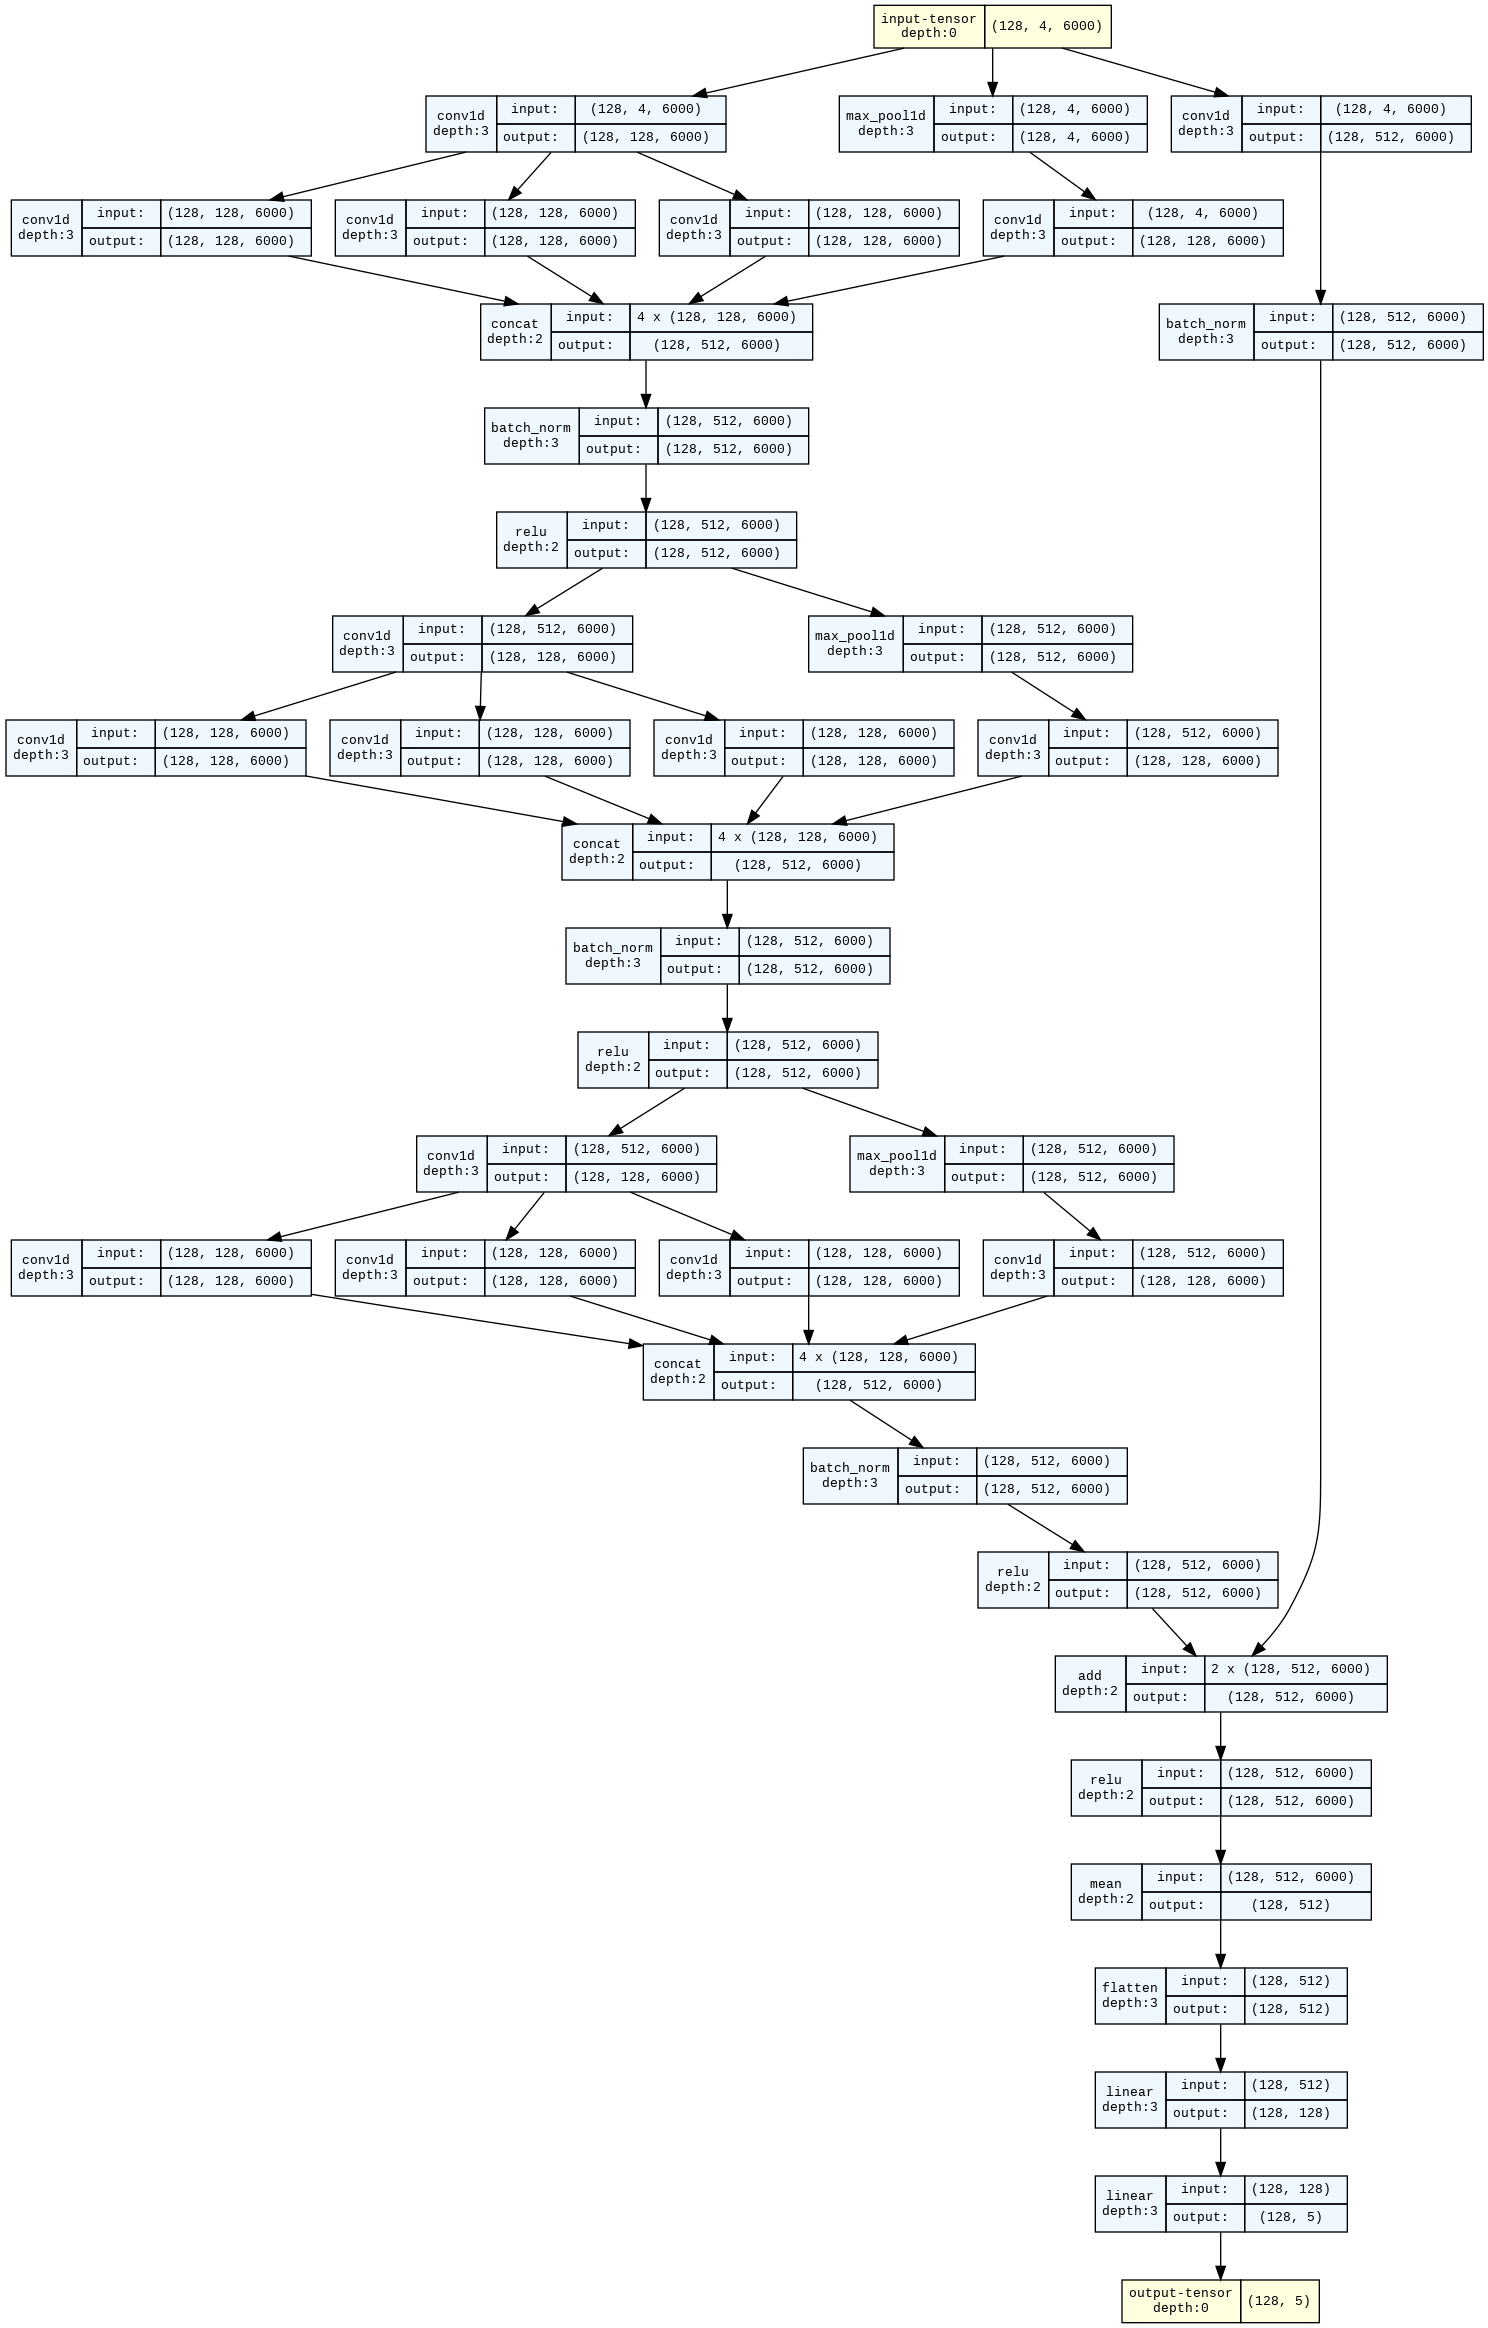

In [ ]:
# @title Network visualisation
model_graph_1 = torchview.draw_graph(
    Inc_model, input_size=(128, 4, 6000),
    graph_name='IncTimeNet',
    hide_inner_tensors=True,
    hide_module_functions=False,
    save_graph = True,
    show_shapes = True,
)
display(Image(filename='/content/IncTimeNet.gv.png'))

Once again, Early stopping was used to train the network with patience of 60 epochs. The winner in terms of validation loss was epoch 107 with training/validation accuracies of 92.5%/87.4%. The network di not overfit as much as ResConvNet, however it was still very unstable on the validation set. Evaluation on the test dataset resulted in accuracy of 87.8%.

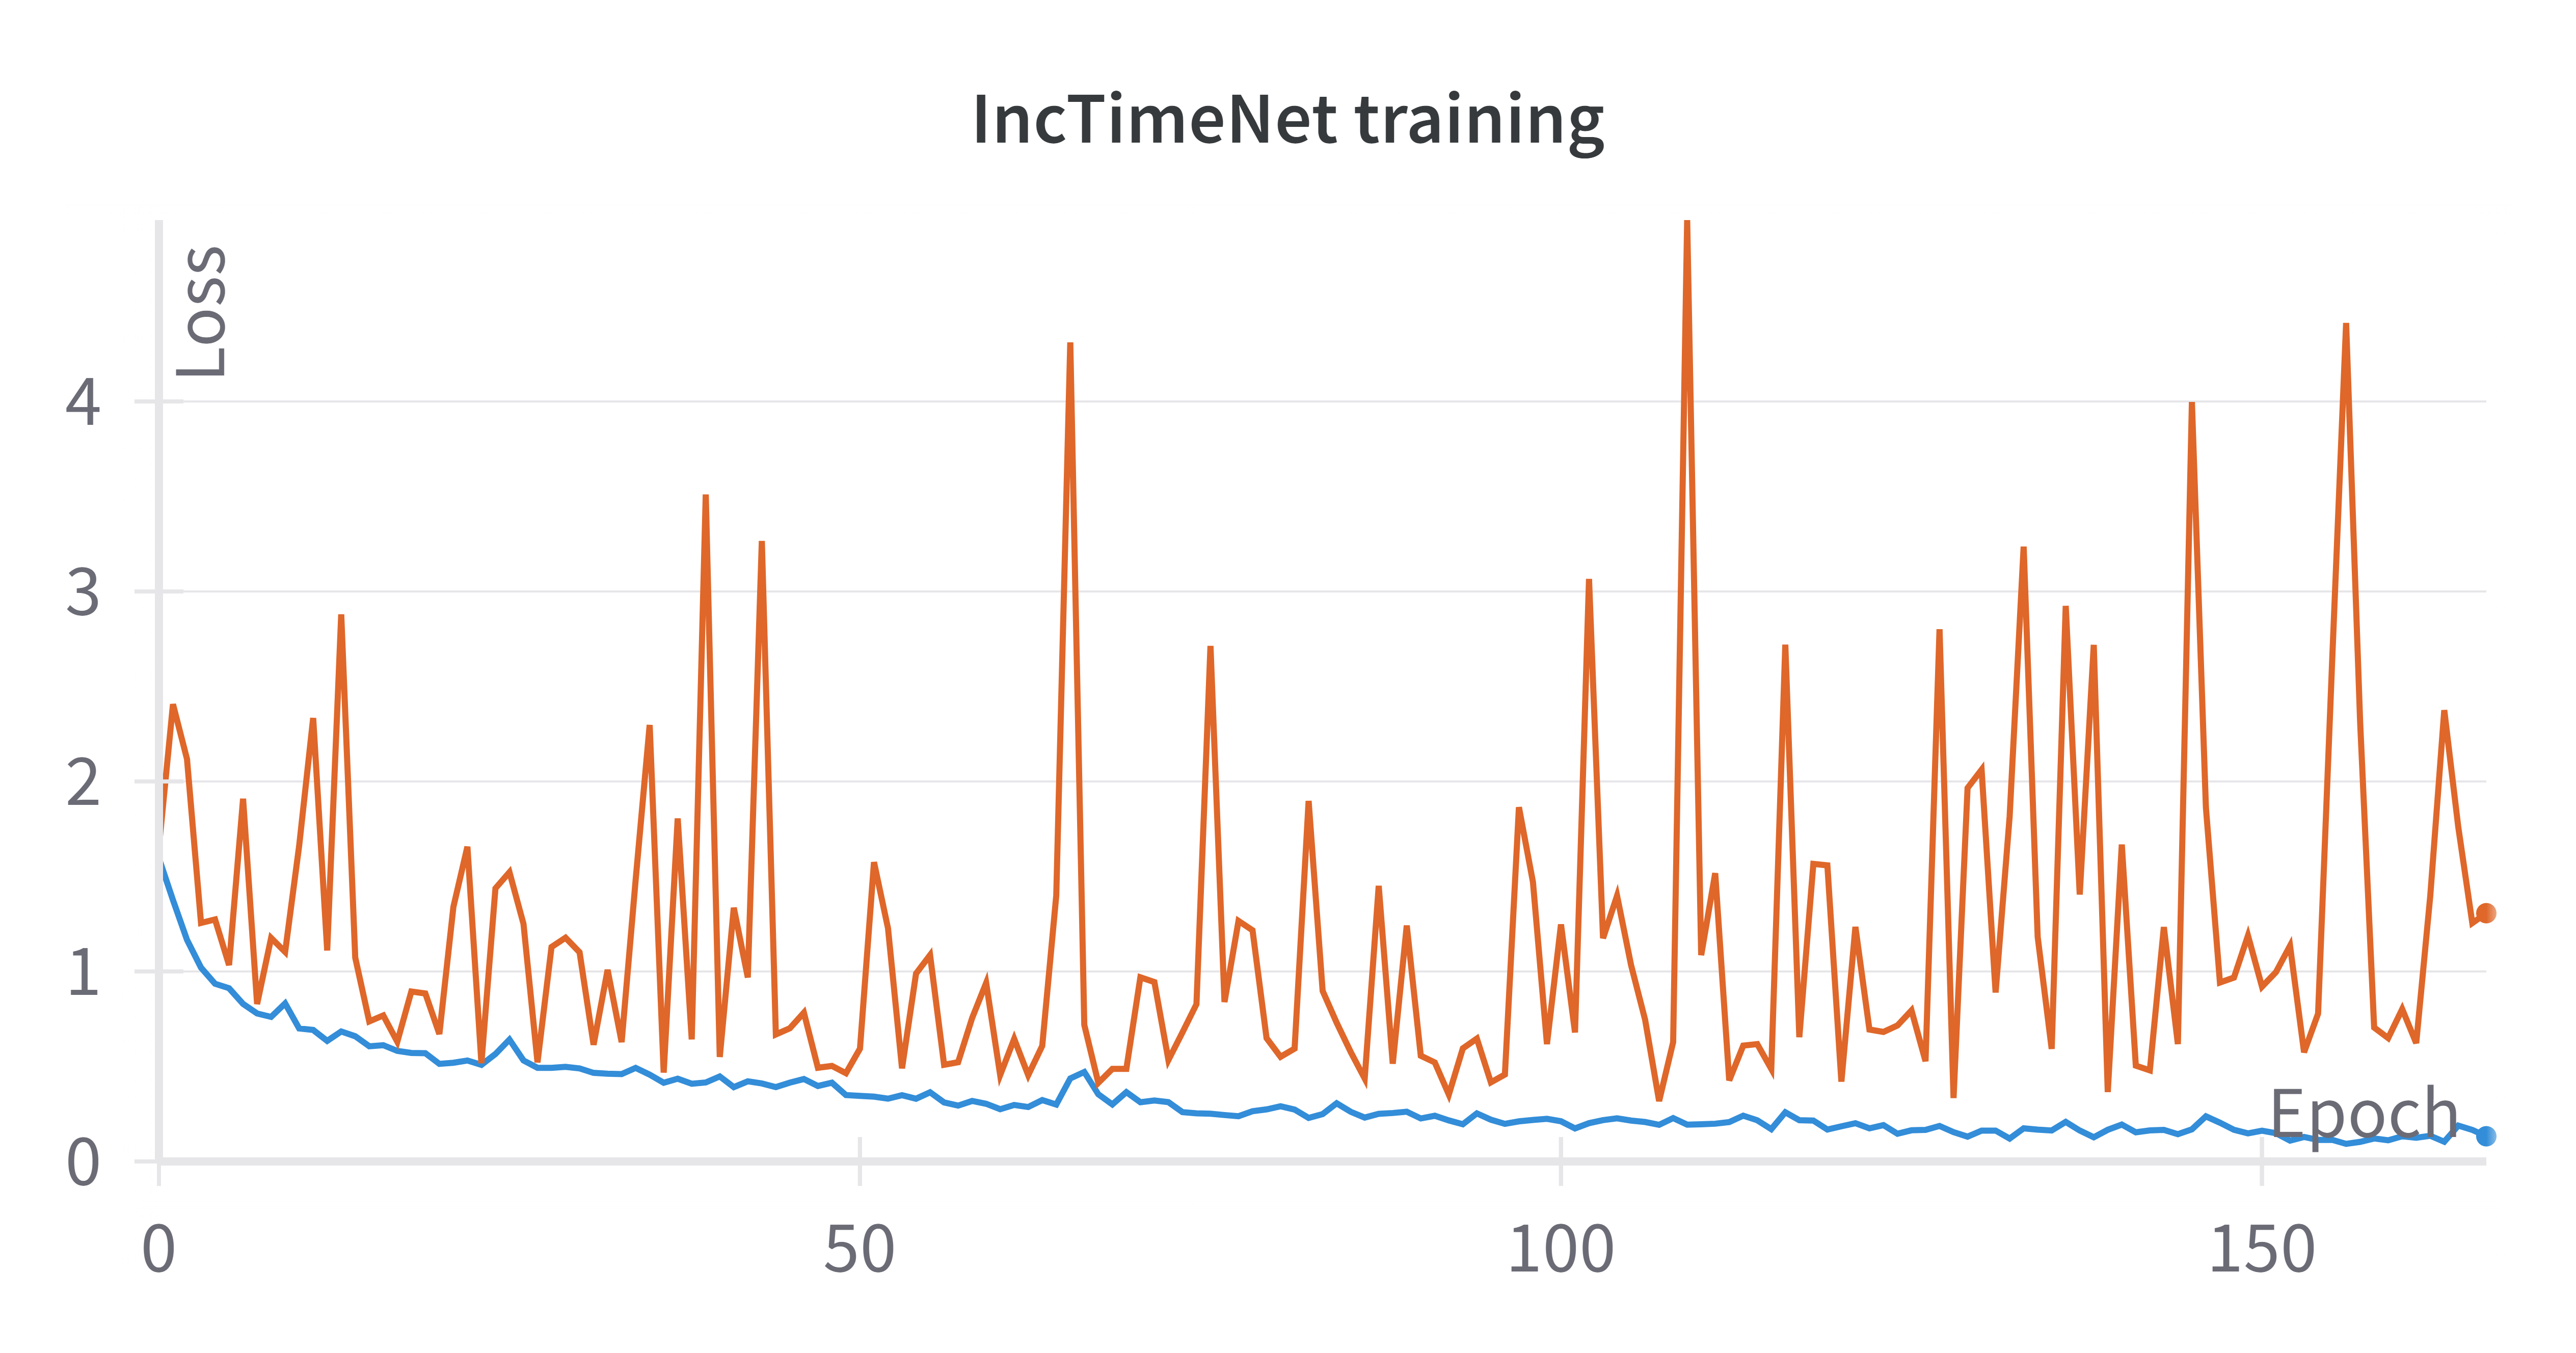

In [ ]:
# Shows loss during training
display(Image(filename='/content/23206-final-acoustic-emission-classification/data/IncTime_training.png'))

In [ ]:
# Evaluation of the test dataset - it takes a while...
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

trainer = pl.Trainer(devices=ngpus, accelerator="gpu" if torch.cuda.is_available() else "cpu", max_epochs = 100, log_every_n_steps = 10)

trainer.test(Inc_model, test_DataLoader)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8784000277519226     │
│         test_loss         │    0.3210640549659729     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3210640549659729, 'test_accuracy': 0.8784000277519226}]

## 4. My_incTime

---
The last implemented network, which was created thanks to a sudden spike of curiosity just before the project deadline, is inspired by InceptionTime architecture but tries to adress some of its downsides we encountered. The main problem with pure InceptionTime, which was designed for shorter signals, seems to be huge memory demands as the length of the signals does not decrease as they pass through the network. To adress this, the Inception module was modified by adding average pooling with kernel of size 2 that cuts the length of the data in half, to keep in track with the length of the data the lengths of filters used decrease in each consecutive Inception module. In parallel with this, the number of channels in each subsequent Inception module increases by a factor of two. Also, to deal with more significant overfitting, dropout layers were introduced into Inception module. In total six inception modules with two residual connections are used. Visualisaton below definition of the network is again very usefuly albeit a bit extensive.

In [ ]:
# @title Definition of pl.LightningModule for My_incTime

class Inception(torch.nn.Module):
    def __init__(self, in_size, out_size, filters = [11, 21, 41], drop = 0.1):
        super(Inception, self).__init__()

        self.bottleneck1 = torch.nn.Conv1d(
            in_channels=in_size,
            out_channels=out_size,
            kernel_size=1,
            stride=1,
            padding='same',
            bias=False
        )

        self.conv1 = torch.nn.Conv1d(
            in_channels=out_size,
            out_channels=out_size,
            kernel_size=filters[0],
            stride=1,
            padding='same',
            bias=False
        )

        self.conv2 = torch.nn.Conv1d(
            in_channels=out_size,
            out_channels=out_size,
            kernel_size=filters[1],
            stride=1,
            padding='same',
            bias=False
        )

        self.conv3 = torch.nn.Conv1d(
            in_channels=out_size,
            out_channels=out_size,
            kernel_size=filters[2],
            stride=1,
            padding='same',
            bias=False
        )

        self.max_pool = torch.nn.MaxPool1d(
            kernel_size=3,
            stride=1,
            padding=1,
        )

        self.bottleneck2 = torch.nn.Conv1d(
            in_channels=in_size,
            out_channels=out_size,
            kernel_size=1,
            stride=1,
            padding='same',
            bias=False
        )

        self.batch_norm = torch.nn.BatchNorm1d(
            num_features=4 * out_size
        )

        self.avg_pool = torch.nn.AvgPool1d(
            kernel_size=2
        )

        self.dropout = torch.nn.Dropout(drop)

    def forward(self, x):
        x0 = self.bottleneck1(x)
        x1 = self.avg_pool(self.dropout(self.conv1(x0)))
        x2 = self.avg_pool(self.dropout(self.conv2(x0)))
        x3 = self.avg_pool(self.dropout(self.conv3(x0)))
        x4 = self.avg_pool(self.dropout(self.bottleneck2(self.max_pool(x))))
        y = torch.concat([x1, x2, x3, x4], dim=1)
        y = torch.nn.functional.relu(self.batch_norm(y))
        return y

class Lambda(torch.nn.Module):

    def __init__(self, f):
        super(Lambda, self).__init__()
        self.f = f

    def forward(self, x):
        return self.f(x)

class Residual(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super(Residual, self).__init__()

        self.bottleneck = torch.nn.Conv1d(
            in_channels=in_size,
            out_channels= 4 * out_size,
            kernel_size=1,
            stride=1,
            padding='same',
            bias=False
        )

        self.avg_pool = torch.nn.AvgPool1d(
            kernel_size=8
        )

        self.batch_norm = torch.nn.BatchNorm1d(
            num_features= 4 * out_size
        )

    def forward(self, x, y):
        y = y + self.avg_pool(self.batch_norm(self.bottleneck(x)))
        y = torch.nn.functional.relu(y)
        return y

class MyInceptionModel(MyModule):
    def __init__(self, in_size, num_classes, out_size, depth, filters = [11, 21, 41], drop = 0.1):
        super(MyInceptionModel, self).__init__()

        self.in_size = in_size
        self.num_classes = num_classes
        self.out_size = out_size
        self.depth = depth

        modules = OrderedDict()

        for d in range(depth):
            modules[f'inception_{d}'] = Inception(
                in_size=in_size if d == 0 else 2**(d-1) * 4 * out_size,
                out_size= out_size if d == 0 else 2**d * out_size,
                filters=[2**(depth-d) + 2, 2**(depth-d+1) + 2, 2**(depth-d+3)+2],
                drop=drop
            )
            if d % 3 == 2:
                modules[f'residual_{d}'] = Residual(
                    in_size=in_size if d == 2 else 2**(d-3) * 4 * out_size,
                    out_size=2**d*out_size,
                )

        modules['avg_pool'] = Lambda(f=lambda x: torch.mean(x, dim=-1))
        #modules['linear'] = torch.nn.Linear(in_features=4 * out_size, out_features=num_classes)

        self.featurizer = torch.nn.Sequential(modules)

        self.classifier = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 2**(depth-1)*4*out_size, out_features=100),
            nn.Linear(in_features = 100, out_features=num_classes)
        )


    def forward(self, x):
        for d in range(self.depth):
            y = self.featurizer.get_submodule(f'inception_{d}')(x if d == 0 else y)
            if d % 3 == 2:
                y = self.featurizer.get_submodule(f'residual_{d}')(x, y)
                x = y
        y = self.featurizer.get_submodule('avg_pool')(y)
        #y = self.model.get_submodule('linear')(y)
        y = self.classifier(y)
        return y



In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Model initialisation
MyInc_model = MyInceptionModel(in_size = 4, num_classes = 5, out_size = 8, depth = 6)
#Loading weights
MyInc_model.load_state_dict(torch.load('/content/23206-final-acoustic-emission-classification/data/My_incTime_state_dict'))
#print(Res_model)

<All keys matched successfully>

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1386: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  ret = func(*args, **kwargs)


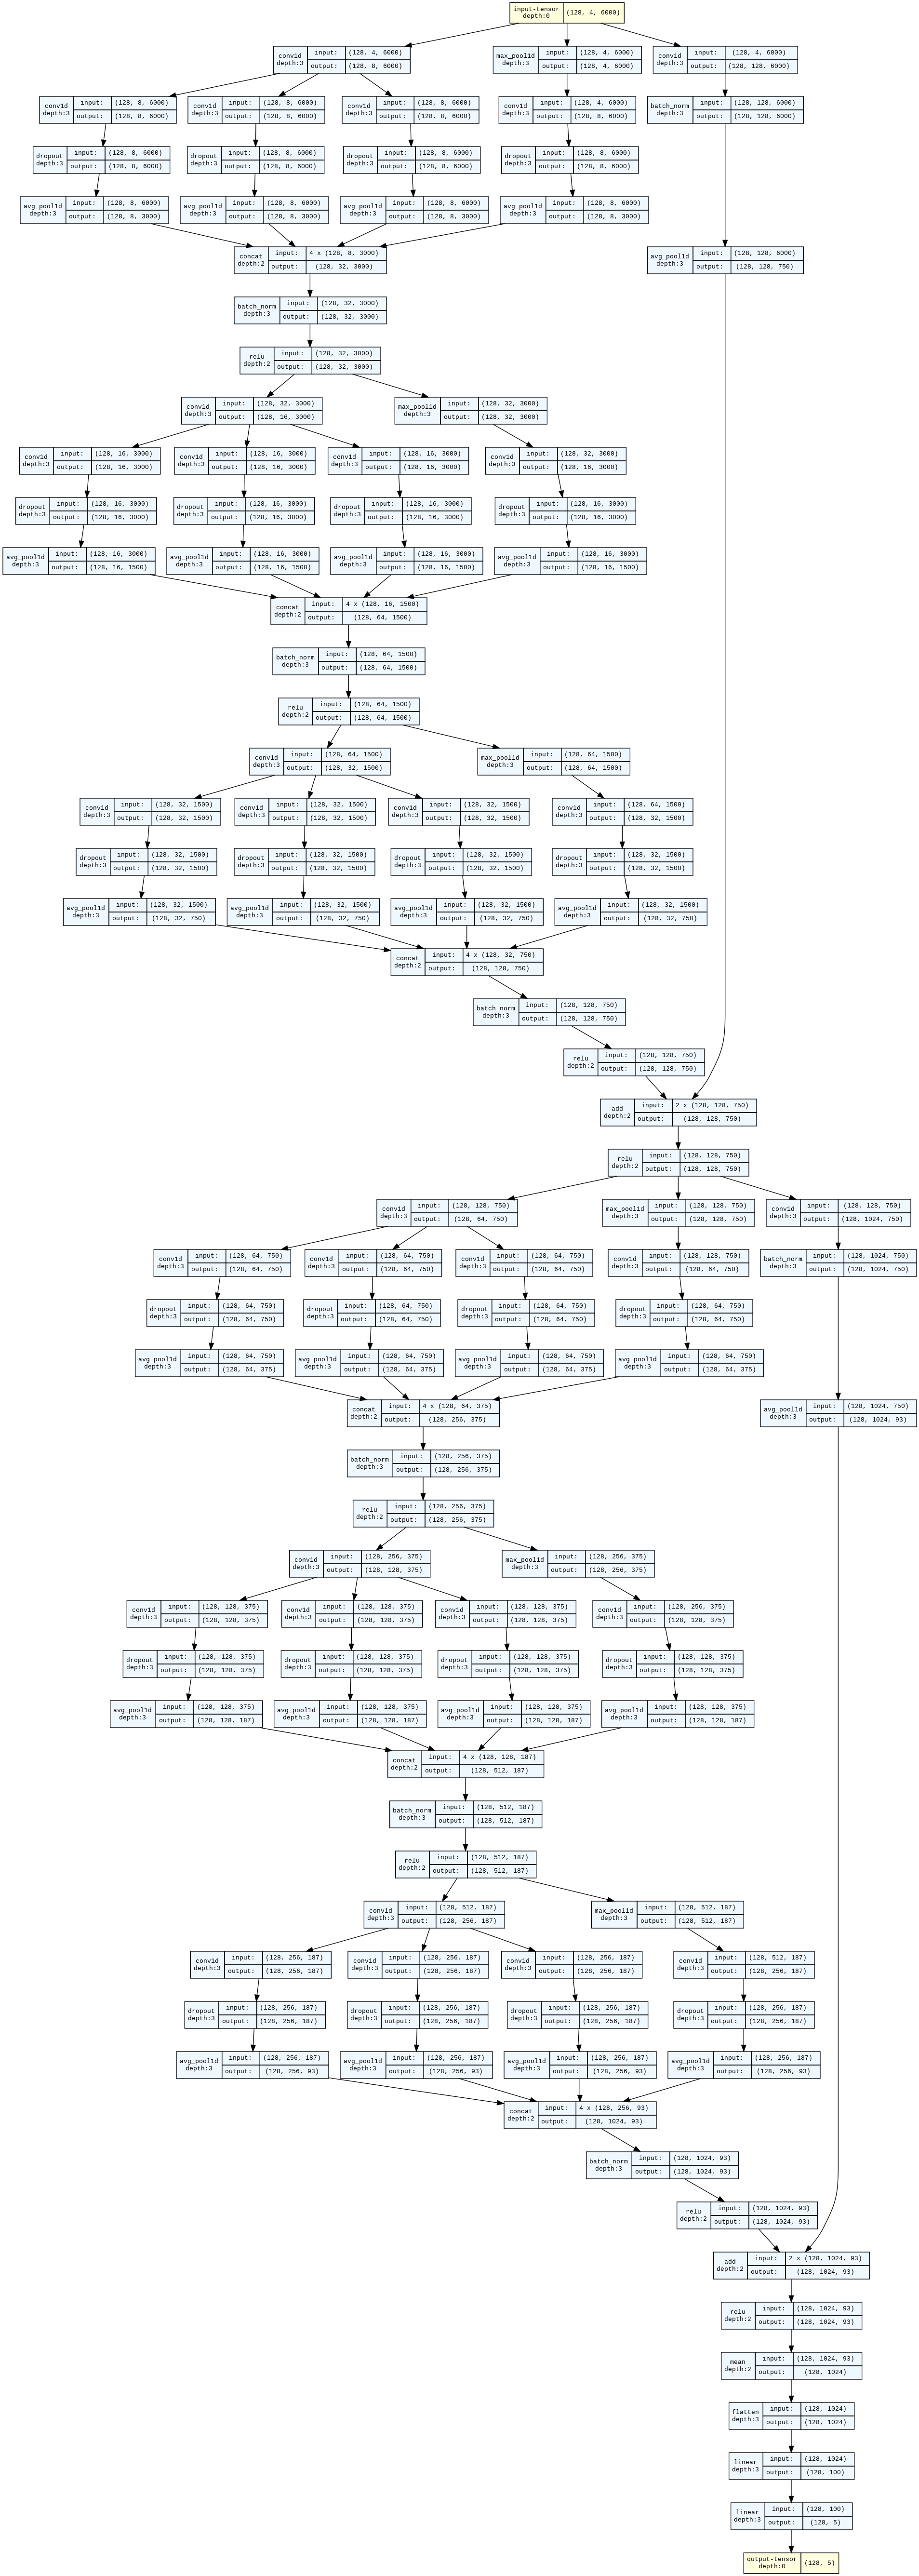

In [ ]:
# @title Network visualisation
model_graph_1 = torchview.draw_graph(
    MyInc_model, input_size=(128, 4, 6000),
    graph_name='MyIncTimeNet',
    hide_inner_tensors=True,
    hide_module_functions=False,
    save_graph = True,
    show_shapes = True,
)
display(Image(filename='/content/MyIncTimeNet.gv.png'))

When beginning to train this network we saw significant overfitting, this was partially solved by using the dropout layer, in the final run we used dropout with 0.3 probability. The lowest validation loss was reached in epoch 81. The network was able to improve classification accuracy of test datased to 89.3%. Further hyperparameter optimization could bring more improvements as the layout used was chosen purely intuitively.

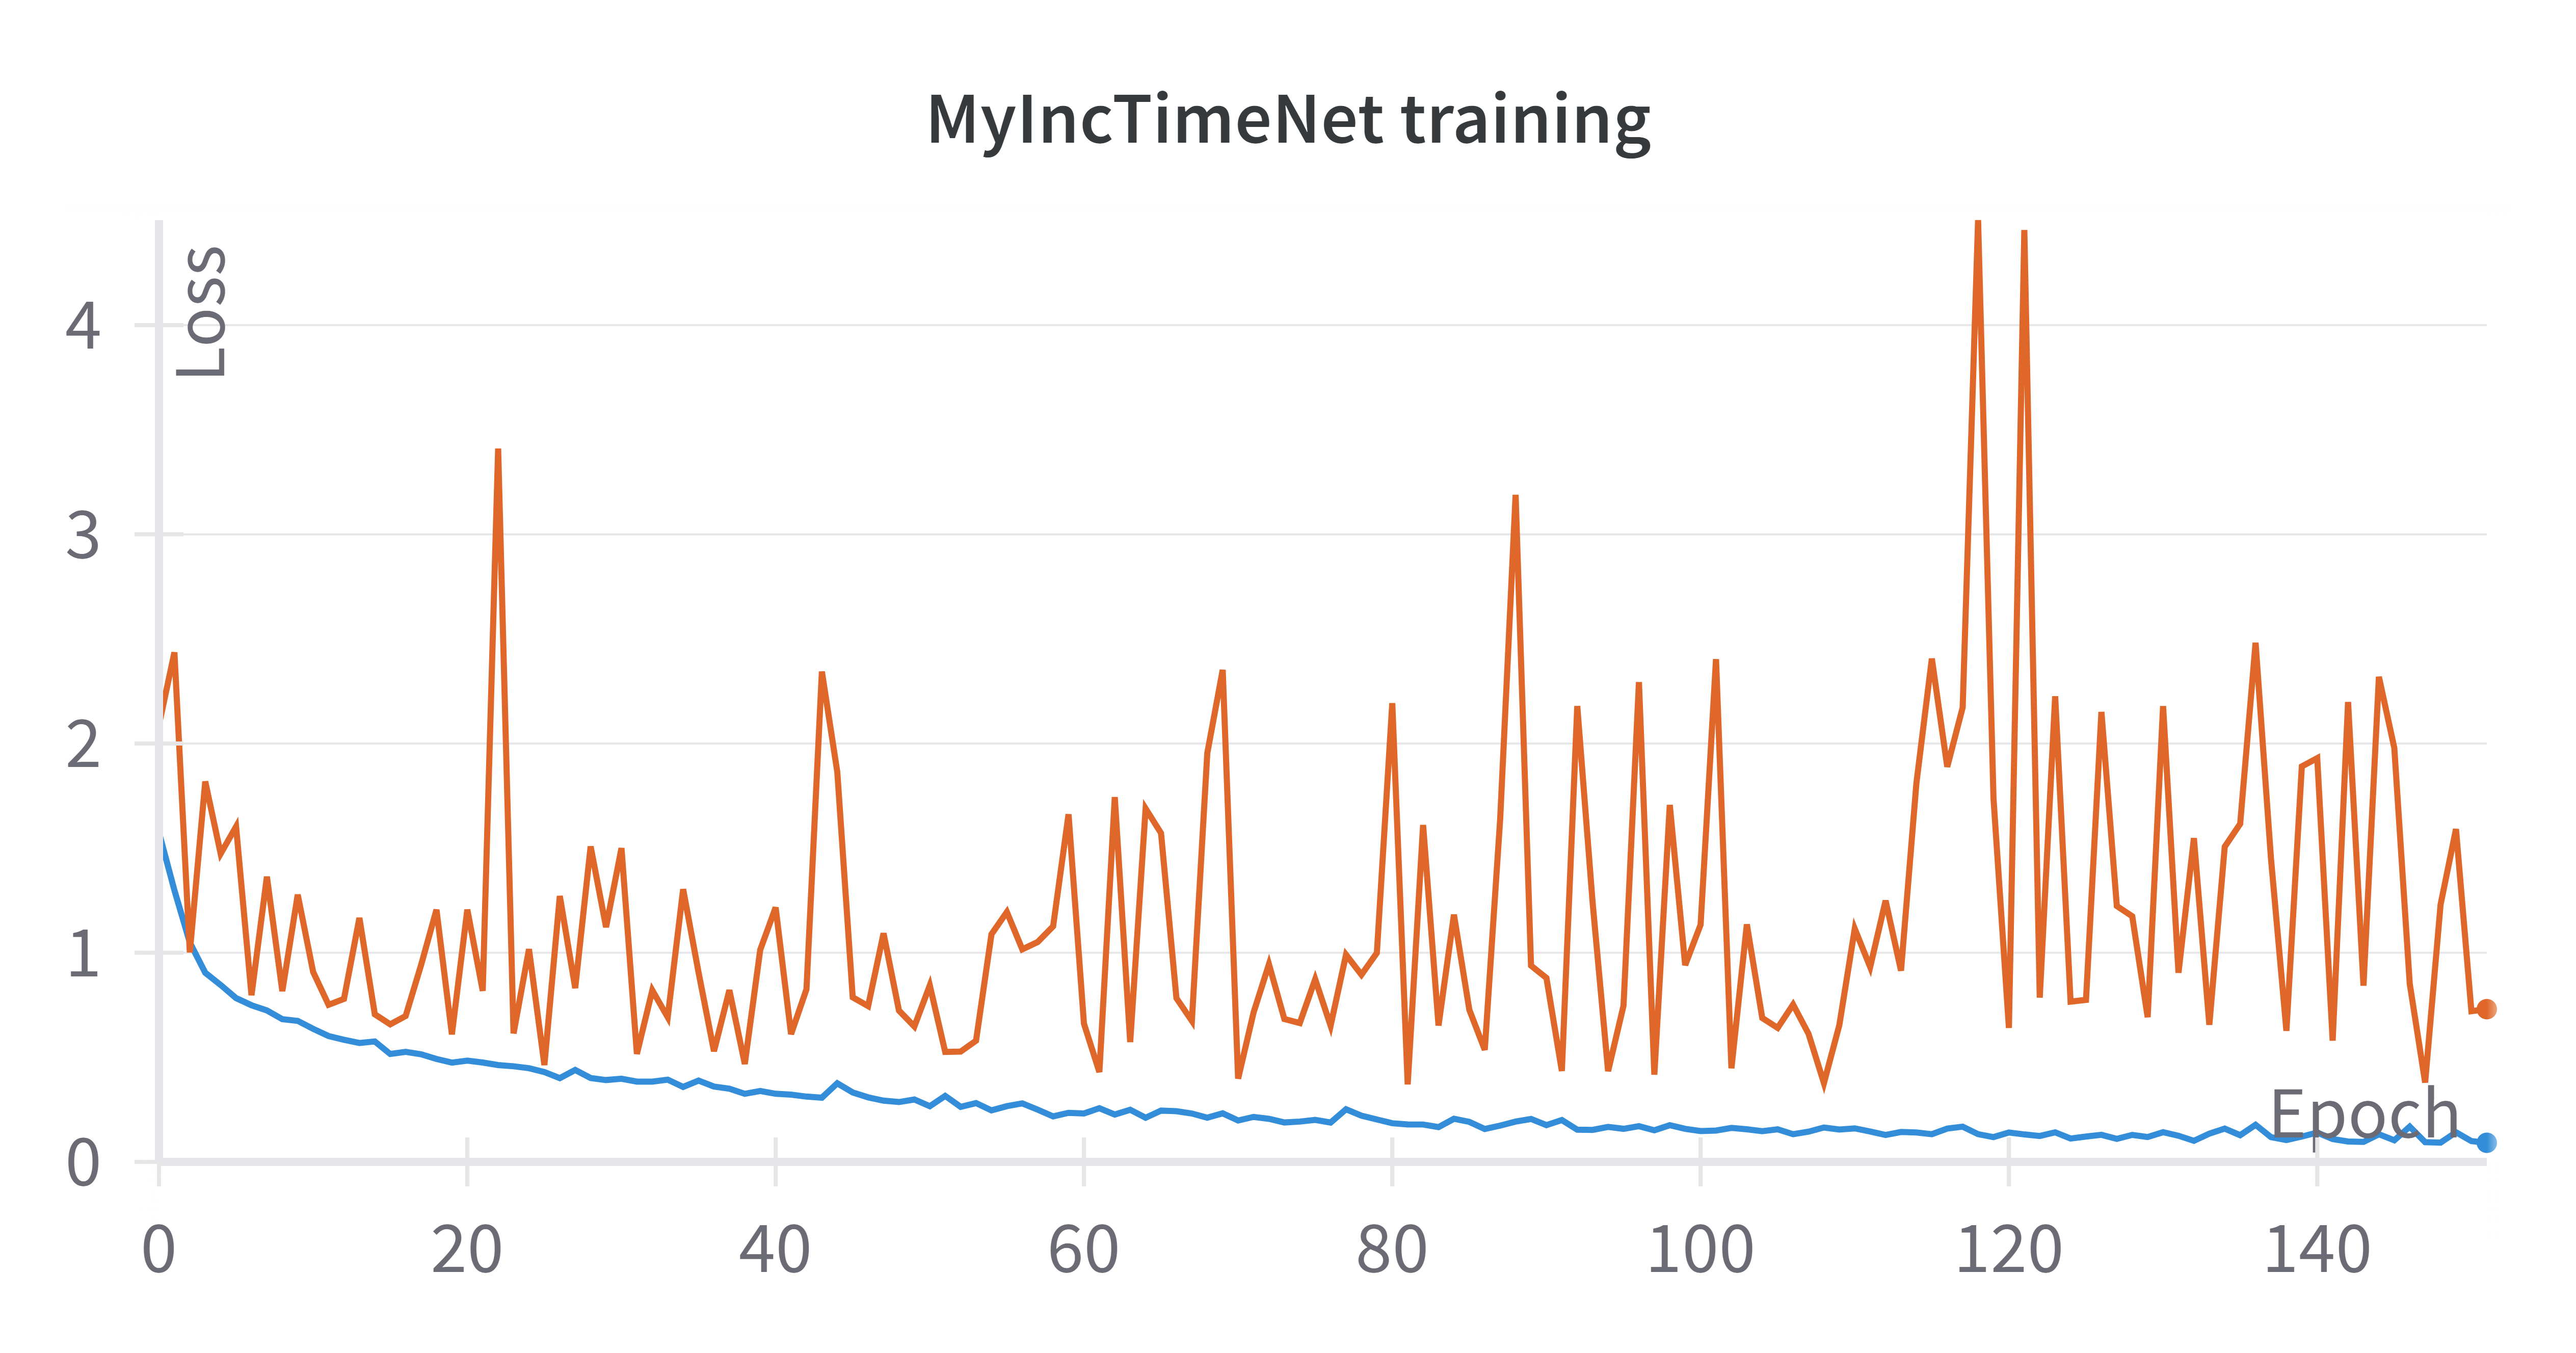

In [ ]:
# Shows loss during training
display(Image(filename='/content/23206-final-acoustic-emission-classification/data/My_incTime.png'))

In [ ]:
# Evaluation of the test dataset
ngpus = torch.cuda.device_count() if torch.cuda.is_available() else 1

trainer = pl.Trainer(devices=ngpus, accelerator="gpu" if torch.cuda.is_available() else "cpu", max_epochs = 100, log_every_n_steps = 10)

trainer.test(MyInc_model, test_DataLoader)

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.892799973487854     │
│         test_loss         │     0.325218141078949     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.325218141078949, 'test_accuracy': 0.892799973487854}]

## Conclusion

Luckily, thanks to [2], we can compare our results with a more traditional approach to classification on the same dataset. In the work a handcrafted feature approach to classification was investigated. With the use of TSFresh package 1121 predefined features were extracted from our dataset, classification was then performed by various methods on these features and on their projection to a low dimensional space (4 projected features). Results of these classifications are displayed in the following table.



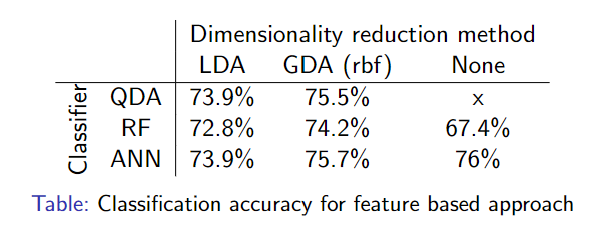

In [ ]:
display(Image('/content/23206-final-acoustic-emission-classification/data/Feature_tab.png'))

LDA (Linear Discriminant Analysis) and GDA (Generalised Discriminant Analysis) are supervised dimensionality reduction techniques. Used classifiers were QDA - a simple Bayesian classifier expecting normal distribution of features, RF (Random Forrest) and ANN - a fully connected neural network.

All of modern classification methods implemented here significantly improved the accuracy of classification with InceptionTime based networks outperforming other networks by a solid margin. Our improvement upon the InceptionTime architecture, for the lack of inspiration named *My_incTime*, reached the best results with classification accuracy of 89.3%. The price of higher computational intensity of convolutional neural networks does not disqualify this approach as it is very demanding to extract the handcrafted features from signals as well.

Potential applications of our findings would be in large scale manufacturing factories, where an online automated supervision could be installed to facilitate on-time control of machining processes. Possible applications are not limited to drilling bits.

## References

[1] I. Fawaz: *InceptionTime: Finding AlexNet for time series classification*, Data Mining and Knowledge Discovery, volume: 34, ISSN: 1573-756X, Springer Science and Business Media LLC, http://dx.doi.org/10.1007/s10618-020-00710-y

[2] J. Zavadil: *Selekce příznaků a klasifikace signálů
akustické emise*. Výzkumný úkol, KM FJFI ČVUT, Praha, 2023.